## Import Libraries

In [1]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Simple Exponential Smoothing models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [2]:
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select column 'Close'
df_Close = df[['Close']]

### Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [7]:
best_alpha = None
best_mse = float('inf')

### Training process

In [8]:
for alpha in np.arange(0.1, 1, 0.1):
    alpha = round(alpha, 1)

    history = train_data
    y_pred_val = []

    for i in val_data:
        model = SimpleExpSmoothing(history)
        model_fit = model.fit(smoothing_level=alpha)
        prediction = model_fit.forecast()
        y_pred_val.append(prediction[0])
        history = np.append(history, i)

    mse = mean_squared_error(val_data, y_pred_val)

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse

In [9]:
print(f"Best alpha: ", best_alpha)

Best alpha:  0.9


### Testing process

In [10]:
y_pred = []

for i in test_data:
  model = SimpleExpSmoothing(history)
  model_fit = model.fit(smoothing_level = best_alpha)
  prediction = model_fit.forecast()
  y_pred.append(prediction[0])
  history = np.append(history, i)

In [11]:
# Evaluate the accuracy of test
test_data = scaler.inverse_transform(test_data)
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_mse = mean_squared_error(test_data, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.031180487943649117
RMSE on Test dataset:  2.853314683742511
MSLE on Test dataset:  0.00247106317218653


## Predicting the next 30 days

### Preparing the forecast date index

In [12]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

### Prediction process

In [13]:
# Predict the closing prices for the next 30 days
y_next_30_days = []

for i in range(30):
  model = SimpleExpSmoothing(history)
  model_fit = model.fit(smoothing_level = 0.7)
  prediction = model_fit.forecast()
  y_next_30_days.append(prediction[0])
  history = np.append(history, prediction[0])

# Print the predicted closing prices for the next 30 days
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[41.62009431 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431
 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431
 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431
 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431
 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431 41.62009431]


## Visualization

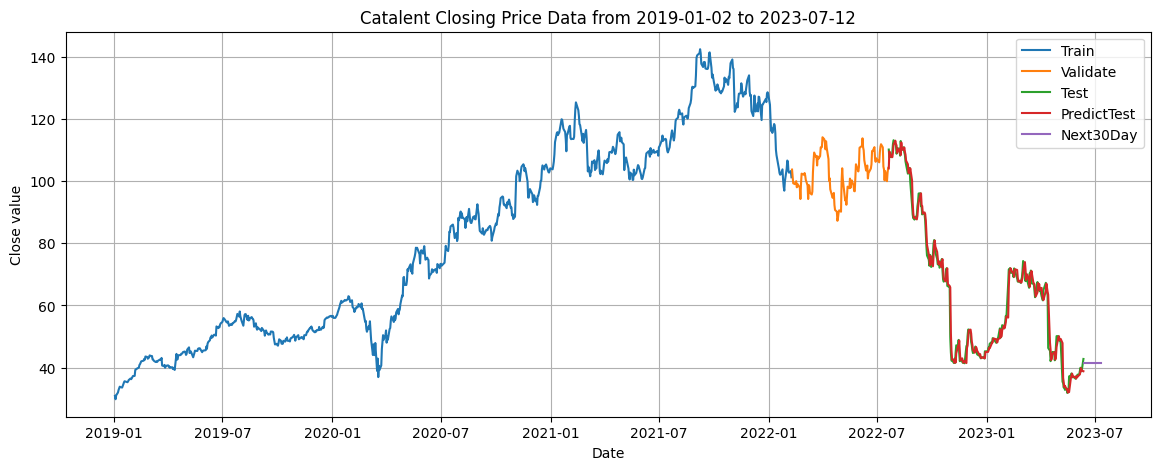

In [14]:
# Drawing
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([train_data]).reshape(-1, 1)).flatten())

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(np.array([val_data]).reshape(-1, 1)).flatten())

plt.plot(df.index[train_size + val_size :], test_data)

plt.plot(df.index[train_size + val_size :], y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('ETS_712_CTLT.png')
plt.show()